In [ ]:
from google.colab import files

In [ ]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install transformers

In [ ]:
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 151MB/s]


In [ ]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train= pd.read_csv('train.csv')

In [ ]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.1, random_state=42)

In [ ]:
# test = pd.read_csv('test.csv')

In [ ]:
train

,id,keyword,location,text,target
4620,6568,injury,"Plano, Texas",'McFadden Reportedly to Test Hamstring Thursda...,0
2858,4107,drought,Nigeria,w--=-=-=-[ NEMA warns Nigerians to prepare for...,1
3098,4448,electrocuted,NaN,When I was cooking earlier I got electrocuted ...,0
3751,5330,fire,Canada,I'm On Fire. http://t.co/WATsmxYTVa,0
5285,7552,outbreak,Indonesia,More than 40 families affected by the fatal ou...,1
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [ ]:
len = train.shape[0]

In [ ]:
df = train

Анализ данных

In [ ]:
df["length"] = df["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df["length"].describe())

Train Length Stat
count    6851.000000
mean      100.889067
std        33.816326
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


In [ ]:
train['target'].value_counts()

0    3916
1    2935
Name: target, dtype: int64

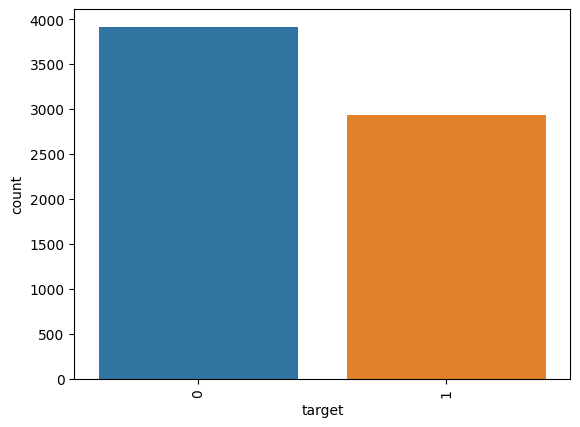

In [ ]:
sns.countplot(x = train["target"])
plotter.xticks(rotation = 90);

## Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
sw = stopwords.words('english')

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) #Замена всего пробелами, кроме (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Удаление URLs

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Удаление html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Удаление пунктуации

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = " ".join(text) #Удаляем стоп слова

    return text

In [ ]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
tweets = df.text.values
labels = df.target.values

## BertTokenizer

В BERT для токенизации используется токенизатор WordPiece (токенизатор подслова). Слово может быть разбито на несколько подслов, что помогает при работе с неизвестными словами.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 0
for sent in tweets:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  45


In [ ]:
input_ids = []
attention_masks = []
max_len = 45

for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True, # Добавдяем специальные токены '[CLS]' и '[SEP]'
                        max_length = max_len,           # Выравниваем все предложения до одной длины и обрезаем их по max_len
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Добавляем attention_mask
                        return_tensors = 'pt',     # Возвращаем pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Преобразуем списки в тензора
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Выведем первое предложение

In [ ]:
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])
print('Mask:', attention_masks[0])

Original:  mcfadden reportedly test hamstring thursday via teamstream http tco jwq kvjh j
Token IDs: tensor([  101, 11338,  7011, 17101,  7283,  3231, 10654,  3367,  4892,  9432,
         3081,  2780, 25379,  8299, 22975,  2080,  1046,  2860,  4160, 24888,
         3501,  2232,  1046,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# Собираем все обучающие данные в TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset)  - train_size

# Рандомно разбиваем датасет
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,480 training samples
1,371 validation samples


In [ ]:
# The DataLoader нелбходимо указать размер батча
batch_size = 32

Создаем DataLoaders для тренировочных и валидационных данных

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Рандомный выбор батчей
            batch_size = batch_size )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Последовательный выбор батчей
            batch_size = batch_size )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Загружаем BertForSequenceClassification - предварительно обученную BERT-модель с одним линейным слоем для классификации

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # Число лейблов
    output_attentions = False, # Нужно ли возвращать attentions weights.
    output_hidden_states = False, # Нужно ли возвращать скрытое состояние hidden-states.
)
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Оптимизатор AdamW


In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
epochs = 4
# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

Get_linear_schedule_with_warmup - планировщик скорости обучения, мягко увеличивает скорость обучения в начале обучения, чтобы избежать внезапных изменений, и плавно снижает ее в конце обучения для более эффективной точной настройки.

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Функция для расчета аккюраси

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten() # одномерный тензор
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))
    #hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    #Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Время каждой эпохи
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Распаковка данных  из dataloader.
        # `batch` содержит three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad() # Сбрасываем градиенты
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()

        # Выполняем обратный проход для расчета градиентов.
        loss.backward()

        # Обрежем градиенты до 1,0. Это необходимо для предотвращения проблемы "взрывающихся градиентов".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Обновить параметры и делаем шаг
        optimizer.step()
        # Обновляем learning rate.
        scheduler.step()

    # Вычисляем average loss для всех батчей.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Время, затраченное на эпоху
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    #--------------------------------------------------------------
    #               Validation

    print("")
    print("Running Validation...")
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Данный метод отключает вычисление градиента, что уменьшает расход памяти на вычисления.
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.49
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.83

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.36
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.83

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.28
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.82

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.22
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.82

Training complete!
Total training took 0:03:17 (h:mm:ss)


In [ ]:
model = torch.load('bert_model')

Подготавливаем тестовые данные

In [ ]:
df_test = pd.read_csv('test.csv')
df_test['text'] = df_test['text'].apply(lambda x:clean_text(x))
test_tweets = df_test['text'].values

In [ ]:
test_input_ids = []
test_attention_masks = []
for tweet in test_tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset), # Берем батчи последовательно
            batch_size = batch_size
        )

Делаем предсказание

In [ ]:
predictions = []
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

In [ ]:
df_output = pd.DataFrame()
df_output['id'] = df_test['id']
df_output['target'] =predictions
df_output.to_csv('submission1.csv',index=False)